Linear Regression Model for Tourism Data 

In [11]:
import os  
import sys

os.getcwd()


'/home/clif_lastrophysicien/ELO2_LAPERLE_HT/4_data_analysis'

Step 1: Understanding the Data

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)


In [14]:
# Set style for better visualizations
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


2: Loading and Exploring the Data

In [16]:
# Load the dataset
df = pd.read_csv("UN_tourism_caribbean_countries_cleaned.csv")

# Display basic information
print("=== DATASET INFORMATION ===")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\n=== BASIC STATISTICS ===")
print(df.describe())

print(f"\n=== UNIQUE VALUES ===")
print(f"Visitor types: {df['type_of_visitors'].unique()}")
print(f"Number of countries: {df['country_receiving'].nunique()}")
print(f"Years range: {df['year'].min()} to {df['year'].max()}")


=== DATASET INFORMATION ===
Shape: (3025, 6)

Columns: ['type_of_visitors', 'country_receiving', 'where_tourist_from', 'year', 'number_of_tourist', 'unit']

Data Types:
type_of_visitors       object
country_receiving      object
where_tourist_from     object
year                    int64
number_of_tourist     float64
unit                   object
dtype: object

Missing Values:
type_of_visitors      0
country_receiving     0
where_tourist_from    0
year                  0
number_of_tourist     0
unit                  0
dtype: int64

First 5 rows:
  type_of_visitors    country_receiving where_tourist_from  year  \
0    excursionists  Antigua and Barbuda              World  1995   
1    excursionists  Antigua and Barbuda              World  1996   
2    excursionists  Antigua and Barbuda              World  1997   
3    excursionists  Antigua and Barbuda              World  1998   
4    excursionists  Antigua and Barbuda              World  1999   

   number_of_tourist            unit  


In [20]:
data.info()

data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type_of_visitors    3025 non-null   object 
 1   country_receiving   3025 non-null   object 
 2   where_tourist_from  3025 non-null   object 
 3   year                3025 non-null   int64  
 4   number_of_tourist   3025 non-null   float64
 5   unit                3025 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 141.9+ KB


,type_of_visitors,country_receiving,where_tourist_from,year,number_of_tourist,unit
0,excursionists,Antigua and Barbuda,World,1995,227.0,thousand trips
1,excursionists,Antigua and Barbuda,World,1996,270.0,thousand trips
2,excursionists,Antigua and Barbuda,World,1997,286.0,thousand trips
3,excursionists,Antigua and Barbuda,World,1998,336.0,thousand trips
4,excursionists,Antigua and Barbuda,World,1999,328.0,thousand trips


 Understanding the Data Structure

  The dataset contains:

  type_of_visitors: Type of visitors (tourists, excursionists, visitors_total)

  country_receiving: Destination country

  where_tourist_from: Origin (all are "World")

  year: Year of data

  number_of_tourist: Number of visitors (in thousand trips)

  unit: Measurement unit (thousand trips)

3. Data Preprocessing

=== HANDLING MISSING VALUES ===
Missing values before cleaning: 0
Missing values after cleaning: 0

=== ENCODING CATEGORICAL VARIABLES ===
Encoded 30 countries
Encoded visitor types: ['excursionists' 'tourists' 'visitors_total']

=== FEATURE ENGINEERING ===
New features created: decade, post_2000, post_2010, covid_period

=== DATA DISTRIBUTION ===


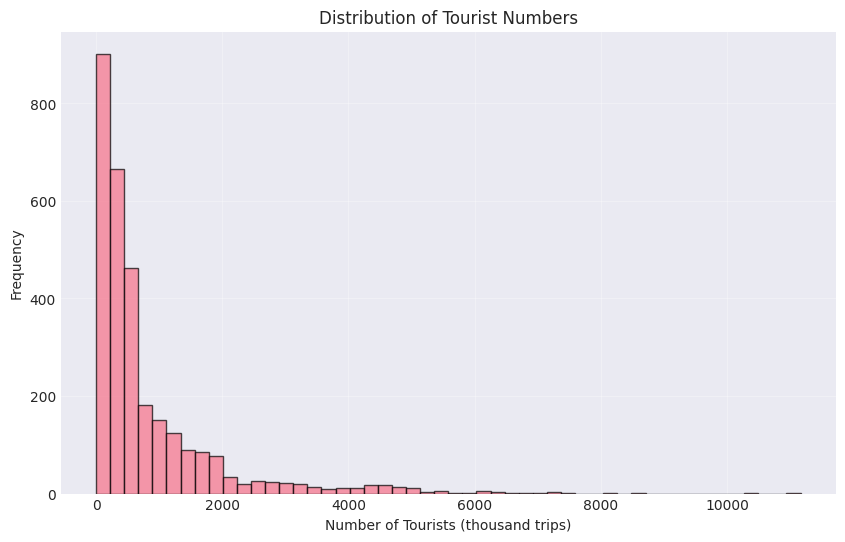

Skewness: 2.99


In [21]:
# Step 3.1: Handle missing values
print("=== HANDLING MISSING VALUES ===")
print(f"Missing values before cleaning: {df.isnull().sum().sum()}")

# Since this is time series data, we'll fill missing values with forward/backward fill
df["number_of_tourist"] = (
    df["number_of_tourist"].fillna(method="ffill").fillna(method="bfill")
)

print(f"Missing values after cleaning: {df.isnull().sum().sum()}")

# Step 3.2: Convert categorical variables to numerical
print("\n=== ENCODING CATEGORICAL VARIABLES ===")

# Create label encoders
country_encoder = LabelEncoder()
visitor_type_encoder = LabelEncoder()

# Encode categorical variables
df["country_encoded"] = country_encoder.fit_transform(df["country_receiving"])
df["visitor_type_encoded"] = visitor_type_encoder.fit_transform(df["type_of_visitors"])

print(f"Encoded {len(country_encoder.classes_)} countries")
print(f"Encoded visitor types: {visitor_type_encoder.classes_}")

# Step 3.3: Feature Engineering
print("\n=== FEATURE ENGINEERING ===")

# Create additional features that might be useful
df["decade"] = (df["year"] // 10) * 10
df["post_2000"] = (df["year"] > 2000).astype(int)
df["post_2010"] = (df["year"] > 2010).astype(int)

# COVID-19 impact indicator (2020-2021)
df["covid_period"] = ((df["year"] >= 2020) & (df["year"] <= 2021)).astype(int)

print("New features created: decade, post_2000, post_2010, covid_period")

# Step 3.4: Check data distribution
print("\n=== DATA DISTRIBUTION ===")
plt.figure(figsize=(10, 6))
plt.hist(df["number_of_tourist"], bins=50, edgecolor="black", alpha=0.7)
plt.title("Distribution of Tourist Numbers")
plt.xlabel("Number of Tourists (thousand trips)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Skewness: {df['number_of_tourist'].skew():.2f}")


4. Exploratory Data Analysis (EDA)

=== CORRELATION ANALYSIS ===


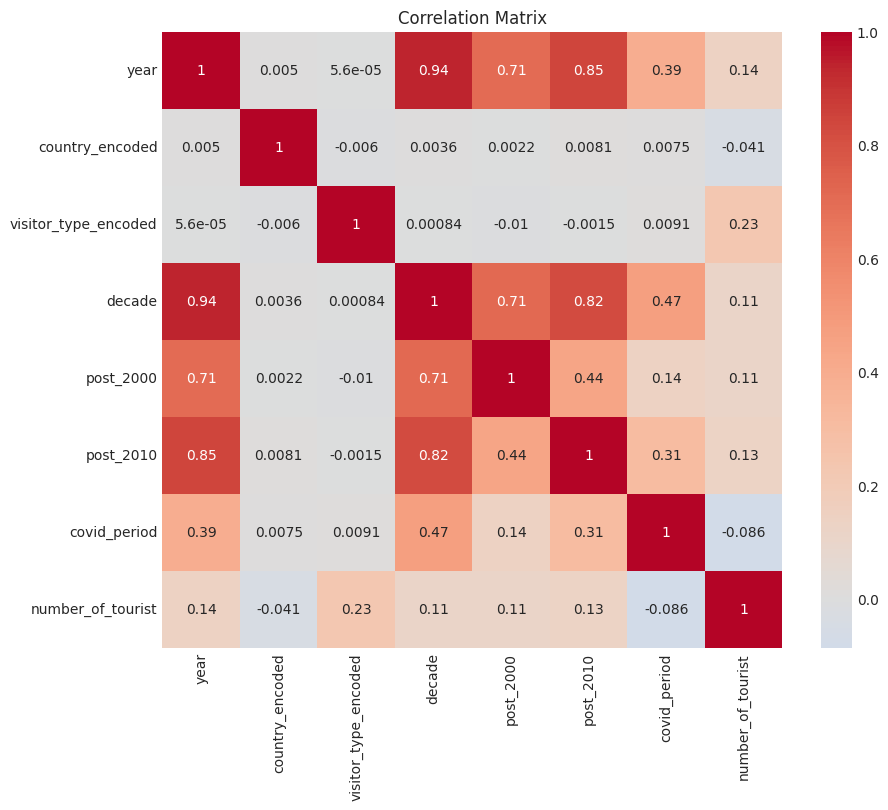


=== TIME SERIES ANALYSIS ===


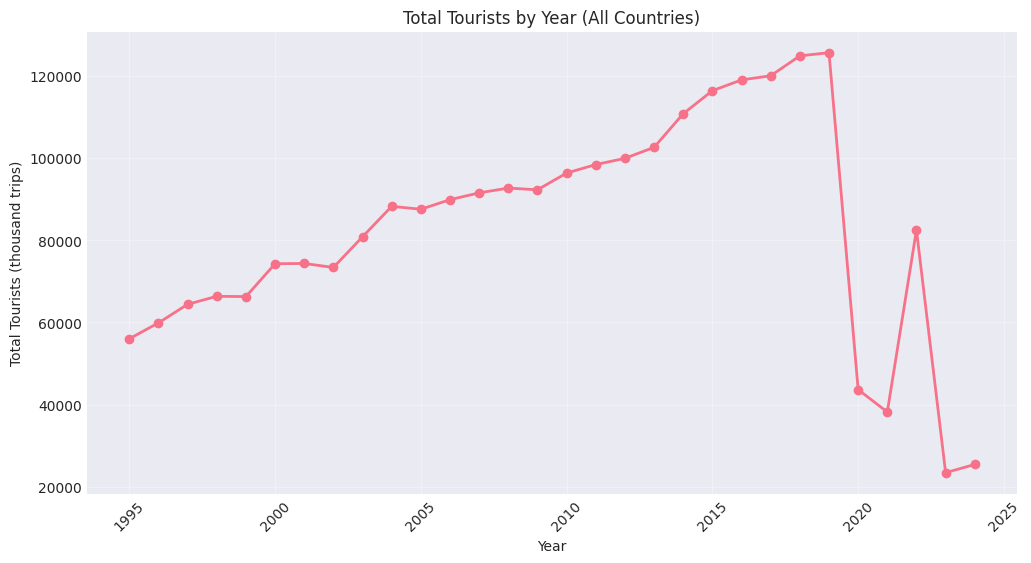


=== VISITOR TYPE ANALYSIS ===
                         mean           sum  count
type_of_visitors                                  
excursionists      624.687716  9.045478e+05   1448
tourists           696.608350  5.593765e+05    803
visitors_total    1320.909455  1.022384e+06    774


In [22]:
# Step 4.1: Correlation Analysis
print("=== CORRELATION ANALYSIS ===")

# Select numerical features for correlation
numerical_features = [
    "year",
    "country_encoded",
    "visitor_type_encoded",
    "decade",
    "post_2000",
    "post_2010",
    "covid_period",
]

# Create correlation matrix
correlation_matrix = df[numerical_features + ["number_of_tourist"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

# Step 4.2: Time Series Analysis
print("\n=== TIME SERIES ANALYSIS ===")

# Aggregate data by year
yearly_tourists = df.groupby("year")["number_of_tourist"].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(
    yearly_tourists["year"],
    yearly_tourists["number_of_tourist"],
    marker="o",
    linewidth=2,
)
plt.title("Total Tourists by Year (All Countries)")
plt.xlabel("Year")
plt.ylabel("Total Tourists (thousand trips)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

# Step 4.3: Visitor Type Analysis
print("\n=== VISITOR TYPE ANALYSIS ===")
visitor_type_stats = df.groupby("type_of_visitors")["number_of_tourist"].agg(
    ["mean", "sum", "count"]
)
print(visitor_type_stats)


5. Preparing Data for Regression

In [23]:
# Step 5.1: Select features and target variable
print("=== PREPARING DATA FOR REGRESSION ===")

# Define features (X) and target (y)
X = df[
    [
        "year",
        "country_encoded",
        "visitor_type_encoded",
        "decade",
        "post_2000",
        "post_2010",
        "covid_period",
    ]
]
y = df["number_of_tourist"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Step 5.2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Step 5.3: Scale the features (optional, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")


=== PREPARING DATA FOR REGRESSION ===
Features shape: (3025, 7)
Target shape: (3025,)

Training set size: 2420 samples
Testing set size: 605 samples
Features scaled using StandardScaler


6. Building the Linear Regression Model

# Step 6.1: Create and train the model
print("=== BUILDING LINEAR REGRESSION MODEL ===")

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

print("Model training completed!")
print(f"\nModel Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_:.2f}")

# Step 6.2: Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print("\nPredictions generated for training and testing sets")

7. Model Evaluation

# Step 7.1: Calculate evaluation metrics
print("=== MODEL EVALUATION ===")

# Training set metrics
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Testing set metrics
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("\n=== TRAINING SET METRICS ===")
print(f"Mean Squared Error (MSE): {train_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {train_mae:.2f}")
print(f"R-squared Score: {train_r2:.2f}")

print("\n=== TESTING SET METRICS ===")
print(f"Mean Squared Error (MSE): {test_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {test_mae:.2f}")
print(f"R-squared Score: {test_r2:.2f}")

# Step 7.2: Visualize predictions vs actual values
print("\n=== VISUALIZING PREDICTIONS ===")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train, y_pred_train, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
            'r--', lw=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title(f'Training Set (R² = {train_r2:.2f})')
axes[0].grid(True, alpha=0.3)

# Testing set
axes[1].scatter(y_test, y_pred_test, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2)
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title(f'Testing Set (R² = {test_r2:.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 7.3: Residual Analysis
print("\n=== RESIDUAL ANALYSIS ===")

residuals = y_test - y_pred_test

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check residual statistics
print(f"Residual mean: {residuals.mean():.2f}")
print(f"Residual std: {residuals.std():.2f}")